# Prioritized buffer Deep Q-Network CNN implementation 


In [1]:
import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/atari_wrappers.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/utils.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/framebuffer.py

!pip -q install gymnasium[atari,accept-rom-license]

!touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack .../xserver-common_2%3a1.20.13-1ubuntu1~20.04.15_all.deb ...
Unpacking xserver-common (2:1.20.13-1ubuntu1~20.04.15) over (2:1.20.13-1ubuntu1~20.04.14) ...
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.15_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.15) over (2:1.20.13-1ubuntu1~20.04.14) ...
Setting up xserver-common (2:1.20.13-1ubuntu1~20.04.15) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.15) ...
Processing triggers for man-db (2.9.1-1) ...
bash: line 9: gdown: command not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
Starting virtual X frame buffer: Xvfb.


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import gymnasium as gym
import random
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image


In [17]:
ENV_NAME = "BreakoutNoFrameskip-v4"

# Preprocessing

In [18]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()



(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 5, 'episode_frame_number': 0, 'frame_number': 0})

In [19]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, img, channel_weights=[0.8, 0.1, 0.1]):
      red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
      obs = channel_weights[0] * red + channel_weights[1] * green + channel_weights[2] * blue
      return obs

    def observation(self, img):
        """what happens to each observation"""
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type


        PIL_img = Image.fromarray(img.astype('uint8'), 'RGB')
        #  * crop image, remove irrelevant parts
        area = (8, 32, 152, 200)
        cropped_img = PIL_img.crop(area)

        #  * resize image to self.img_size
        res_img = cropped_img.resize((64, 64))

        #  * cast image to grayscale
        gray_image = self._to_gray_scale(np.array(res_img))

        #  * convert image pixels to (0,1) range, float32 type
        gray_image = gray_image/255

        image = gray_image.astype(np.float32)
        image = np.expand_dims(image, axis=0)

        return image

In [20]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer


In [21]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

# DQN as it is

In [22]:

import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cpu')

In [23]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        self.layer1 = nn.Sequential(nn.Conv2d(4, 16, kernel_size=(3,3), stride=2), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3,3), stride=2), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3,3), stride=2), nn.ReLU())
        self.layer4 = nn.Linear(3136, 256)
        self.layer5 = nn.ReLU()
        self.layer6 = nn.Linear(256, n_actions)




    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = self.layer1(state_t)
        qvalues = self.layer2(qvalues)
        qvalues = self.layer3(qvalues).flatten(start_dim=1)
        qvalues = self.layer4(qvalues)
        qvalues = self.layer5(qvalues)
        qvalues = self.layer6(qvalues)

        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states.to(device=device))
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [24]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [25]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

# Experience Replay


In [26]:
class SumTree():
    """
    Stores the priorities in sum-tree structure for effecient sampling.
    Tree structure and array storage:
    Tree index:
         0         -> storing priority sum
        / \
      1     2
     / \   / \
    3   4 5   6    -> storing priority for transitions
    Array type for storing:
    [0,1,2,3,4,5,6]
    """

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1) + math.ulp(1.0)

        # [--------------parent nodes-------------][-------leaves to record priority-------]
        #             size: capacity - 1                       size: capacity

    def update(self, idx, p):
        """
        input: idx - int, id of leaf to update
        input: p - float, new priority value
        """
        assert idx < self.capacity, "SumTree overflow"

        idx += self.capacity - 1  # going to leaf №i

        change = p - self.tree[idx]
        self.tree[idx] = p
        while idx != 0:    # faster than the recursive loop
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, v):
        """
        input: v - float, cumulative priority of first i leafs
        output: i - int, selected index
        """
        parent_idx = 0
        while True:
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx] or self.tree[cr_idx] == 0.0:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        return leaf_idx - (self.capacity - 1)

    def __getitem__(self, indices):
        return self.tree[indices + self.capacity - 1]

    @property
    def total_p(self):
        return self.tree[0]  # the root is sum of all priorities

In [27]:
class ReplayBuffer(object):
    def __init__(self, size, clip_priorities=1.0, rp_alpha=0.4, inv_beta = 0.6):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self.inv_beta = inv_beta
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE
        self.clip_priorities = clip_priorities
        self.rp_alpha = rp_alpha
        self.size = size
        self.priorities_sum = SumTree(size)
        self.first = True



    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
            # add data to storage
        if len(self._storage) < maxsize:
          self._storage.append(data)
        else:
          self._storage.pop(0)
          self._storage.append(data)




    def sample_indices(self, batch_size):
        '''
        Samples indices using priorities
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        indices: np.array
            batch of indices to sample from replay buffer
        weights: np.array
            batch of importance sampling weights
        """
        '''
        # sample batch_size indices
        indices = np.zeros(batch_size, dtype = np.int32)
        weights = np.ones(batch_size, dtype = np.float64)
        for i in range(batch_size):
            prob = random.random() * (self.priorities_sum.total_p)
            idx = self.priorities_sum.get_leaf(prob)
            indices[i] = idx

        if self.first == True:

            indices = np.random.choice(np.arange(1, min(self.size, len(self._storage))), batch_size)
            self.first = False



        # you can change this to implement bias correction
        weights = np.ones(batch_size)
        min_prob = np.sort(self.priorities_sum.tree) / (self.priorities_sum.total_p)
        if np.sum([min_prob>0]) == 0:
            norm_prob = random.random()
        else:
            norm_prob = np.mean(min_prob[min_prob>0])
        max_weight = norm_prob  ** (-(1 - self.inv_beta))
        if self.priorities_sum.total_p > 0:
            for i in range(batch_size):
                idx = indices[i]
                prob = self.priorities_sum.__getitem__(idx) / (self.priorities_sum.total_p)

                weights[i] =  (prob * self.size + math.ulp(1.0)) ** (-(1 - self.inv_beta))
        weights = weights / max_weight


        return indices, weights


    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        storage = self._storage
        # <YOUR CODE>
            # randomly generate batch_size integers
            # to be used as indexes of samples
        indices, weights = self.sample_indices(batch_size)
        obs_batch = np.zeros((batch_size, np.shape(storage[0][0])[0], np.shape(storage[0][0])[1], np.shape(storage[0][0])[2]))
        act_batch = np.zeros(batch_size, dtype = np.int8) # Actions is some kind of int from 0,1,2,3
        rew_batch = np.zeros(batch_size, dtype = np.int8) # Reward is int from atari page
        next_obs_batch = np.zeros((batch_size, np.shape(storage[0][0])[0], np.shape(storage[0][0])[1], np.shape(storage[0][0])[2]))
        done_mask = np.zeros(batch_size, dtype = np.bool_) #either 0 or 1, so it makes sense to choose bool
        # <YOUR CODE>
            # collect <s,a,r,s',done> for each index

        for i, g in enumerate(indices):
          obs_batch[i] = storage[g][0]
          act_batch[i] = storage[g][1]
          rew_batch[i] = storage[g][2]
          next_obs_batch[i] = storage[g][3]
          done_mask[i] = storage[g][4]
        return (obs_batch, act_batch, rew_batch, next_obs_batch, done_mask), indices, weights

            # <states>, <actions>, <rewards>, <next_states>, <is_done>
    def update_priorities(self, indices, new_priorities):
        '''
        Updates priorities with new_priorities on given indices.
        Parameters
        ----------
        indices: np.array
            indices to update
        new_priorities: np.array
            new priorities to set
        '''
        new_priorities = (new_priorities).clip(min=1e-5, max=self.clip_priorities)

        # update priorities
        for idx, priority in zip(indices, new_priorities):
            priority_alpha = priority ** self.rp_alpha
            self.priorities_sum.update(idx, priority_alpha)






In [28]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    if len(np.shape(s)) != 4:
      s = np.expand_dims(s, axis=0)
    sum_rewards = 0


    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
      q_value = agent.get_qvalues(s)
      action = agent.sample_actions(q_value)[0]
      obs, rew, done, _, _ = env.step(action)


      exp_replay.add(np.squeeze(s, axis=0), action, rew, obs, done)



      s = obs
      s = np.expand_dims(s, axis=0)
      sum_rewards += rew

      if done == True:
        s, _ = env.reset()
        if len(np.shape(s)) != 4:
          s = np.expand_dims(s, axis=0)


    return sum_rewards, s



In [29]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    (obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch), _, _ = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


In [30]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Learning with... Q-learning


In [40]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1).values

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * is_not_done * next_state_values

    assert target_qvalues_for_actions.requires_grad == False, "do not send gradients to target!"

    # mean squared error loss to minimize
    loss = (predicted_qvalues_for_actions - target_qvalues_for_actions)**2

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

# Main loop


In [54]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


In [59]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pickle


In [60]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [61]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [62]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [63]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 100
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [64]:
init_inv_beta = 0.4
final_inv_beta = 0

In [65]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 10000, epsilon = 0.79300, beta = 0.69200

Weights = tensor([7.5984e-05, 5.7526e-05, 8.1837e-05, 2.0968e-04, 8.1837e-05, 8.8895e-05,

        1.5293e-04, 6.3426e-05, 1.5293e-04, 1.2992e-04, 8.2566e-05, 1.0955e-04,

        6.3426e-05, 6.1404e-05, 8.0832e-05, 7.5984e-05, 9.1404e-05, 8.0832e-05,

        7.5984e-05, 9.1404e-05, 8.1837e-05, 4.4782e-04, 7.5984e-05, 6.3426e-05,

        1.0955e-04, 6.1404e-05, 5.7526e-05, 7.5984e-05, 8.8895e-05, 7.5984e-05,

        8.8895e-05, 1.1625e-04], device='cuda:0')

Indicies = [6402 6105 2343 9915 2343 8454 7575 7624 7575 3289 4431 5019 7624 2025

 8862 6402 5242 8862 6402 5242 2343 6358 6402 7624 5019 2025 6105 6402

 8454 6402 8454 1566]


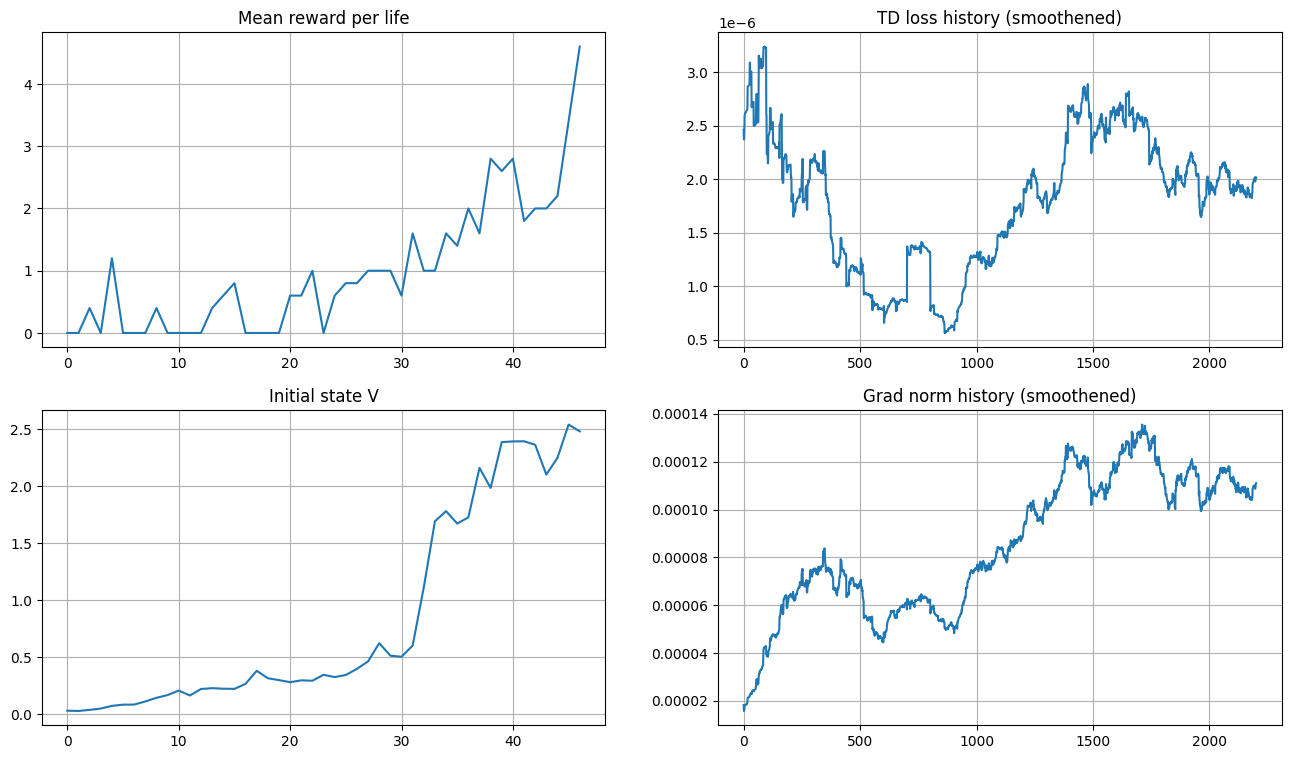

  8%|▊         | 230000/3000001 [1:01:42<12:23:08, 62.12it/s]


In [66]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    exp_replay.inv_beta = utils.linear_decay(init_inv_beta, final_inv_beta, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    (states, actions, rewards, next_states, is_done), indices, weights = exp_replay.sample(batch_size)


    loss_by_sample = compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device)
    weights = torch.FloatTensor(weights.reshape(-1, 1)).to(device)
    loss = torch.mean(loss_by_sample * weights)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    loss_prior = loss_by_sample.detach().cpu().numpy()
    new_priorities = loss_prior + 1e-6
    exp_replay.update_priorities(indices, new_priorities)


    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, beta = %.5f"  %
              (len(exp_replay), agent.epsilon, 1 - exp_replay.inv_beta))
        print(f"Weights = {torch.clone(weights).T[0]}")
        print(f"Indicies = {indices}")


        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

    if mean_rw_history[-1] > 4:
        torch.save(target_network.state_dict(), 'PB_target_network.pth' )
        torch.save(agent.state_dict(), 'PB_agent.pth')
        save_object(exp_replay, 'PB_exp_replay.pkl')

        break


buffer size = 10000, epsilon = 0.84250, beta = 0.67000

Weights = tensor([1.3638e-04, 1.0523e-04, 1.3019e-04, 9.1725e-05, 8.6766e-05, 8.7493e-05,

        9.1725e-05, 7.5341e-05, 8.7493e-05, 8.6766e-05, 8.8920e-05, 9.1725e-05,

        7.5341e-05, 1.3606e-04, 8.7493e-05, 1.3606e-04, 7.5341e-05, 1.0196e-04,

        1.3190e-04, 8.6766e-05, 8.6766e-05, 1.8007e-04, 8.8920e-05, 1.3606e-04,

        8.8920e-05, 1.4615e-04, 1.4615e-04, 7.5341e-05, 1.3638e-04, 1.8007e-04,

        8.7493e-05, 8.6766e-05], device='cuda:0')

Indicies = [7624 1770 9445 4431 3156 3510 4431 8862 3510 3156 9915 4431 8862 6402

 3510 6402 8862 6601 9229 3156 3156 2025 9915 6402 9915 5498 5498 8862

 7624 2025 3510 3156]


  6%|▌         | 174995/3000001 [52:45<10:56:28, 71.72it/s]

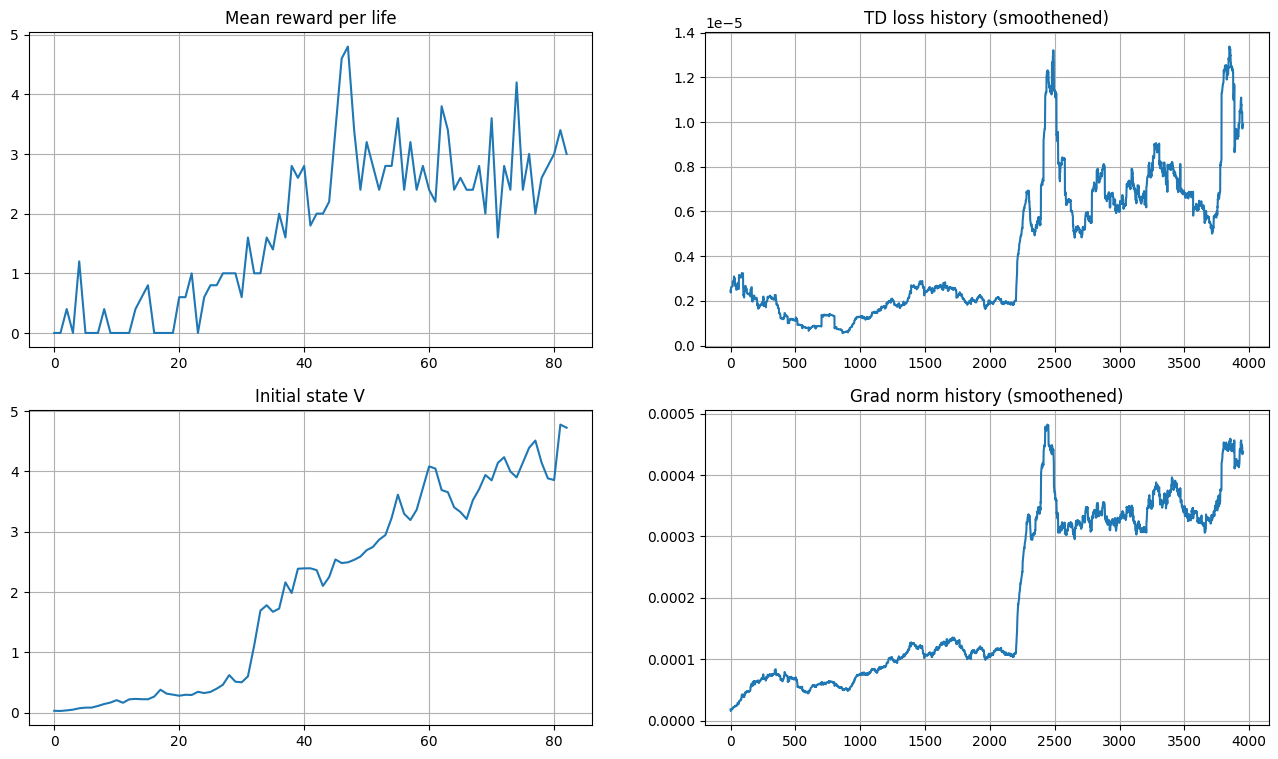

  6%|▌         | 175451/3000001 [52:53<14:11:23, 55.29it/s] 


KeyboardInterrupt: 

In [70]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    exp_replay.inv_beta = utils.linear_decay(init_inv_beta, final_inv_beta, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    (states, actions, rewards, next_states, is_done), indices, weights = exp_replay.sample(batch_size)


    loss_by_sample = compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device)
    weights = torch.FloatTensor(weights.reshape(-1, 1)).to(device)
    loss = torch.mean(loss_by_sample * weights)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    loss_prior = loss_by_sample.detach().cpu().numpy()
    new_priorities = loss_prior + 1e-6
    exp_replay.update_priorities(indices, new_priorities)


    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, beta = %.5f"  %
              (len(exp_replay), agent.epsilon, 1 - exp_replay.inv_beta))
        print(f"Weights = {torch.clone(weights).T[0]}")
        print(f"Indicies = {indices}")


        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()


In [ ]:
agent.load_state_dict(torch.load('/kaggle/working/PB_agent.pth'))
target_network.load_state_dict(torch.load('/kaggle/working/PB_target_network.pth'))

In [67]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 15, 'not as cool as DQN can'
print('Cool!')

final score: 29.0

Cool!
